In [16]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
import itertools

In [17]:
max_length = 0
corpus = list()
labels = list()

with open(Path('./output/benign/all_benign.txt'), 'r') as f:
  lines = f.read().split('\n')[:-1]
  # print(lines[0][33:])
for line in lines:
  doc = line[33:]
  corpus.append(doc)
  labels.append(0)
  

In [18]:
with open(Path('./output/malware/all_malware.txt'), 'r') as f:
  lines = f.read().split('\n')[:-1]
  # print(lines[0][33:])
doc = ''
for line in lines:
  doc = line[33:]
  corpus.append(doc)
  labels.append(1)

In [19]:
labels = np.array(labels)

In [20]:
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(corpus)
X = tokenizer.texts_to_sequences(corpus)
X = pad_sequences(X, maxlen=192000)
print(X.shape)

(2800, 192000)


In [21]:
X = X.reshape(-1, 128, 1500)
print(X.shape)

(2800, 128, 1500)


In [22]:
vocab_size = len(tokenizer.word_index) + 1
print(f'노드 개수: {vocab_size}, 한 개 밖에 없는 노드:', end=' ')
unique_word = 0
for k in tokenizer.word_docs:
  if tokenizer.word_docs[k] == 1:
    unique_word += 1
print(unique_word)

노드 개수: 26, 한 개 밖에 없는 노드: 0


In [8]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10955123044015531610,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 32479379456
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15335105505203170502
 physical_device_desc: "device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0"]

In [9]:
LSTM_model = Sequential()
LSTM_model.add(Bidirectional(LSTM(units=256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
                        input_shape=(128, 1500)))
LSTM_model.add(Bidirectional(LSTM(units=256, dropout=0.2, recurrent_dropout=0.2)))
LSTM_model.add(Dense(1, activation='sigmoid'))
LSTM_model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
print(LSTM_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 128, 512)          3598336   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 5,173,761
Trainable params: 5,173,761
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.1, random_state=0)
print(f'Train을 {X_train.shape}만큼, Test를 {X_test.shape}만큼 진행')

Train을 (2520, 128, 1500)만큼, Test를 (280, 128, 1500)만큼 진행


In [11]:
batch_size = 256
mc = ModelCheckpoint('./log/model2.h5', save_best_only=True)
history = LSTM_model.fit(X_train, y_train, epochs=100, batch_size=batch_size,
                    verbose=1, validation_split=0.1, callbacks=[mc])


Epoch 1/100
9/9 [==============================] - 24s 2s/step - loss: 0.7410 - accuracy: 0.5789 - val_loss: 0.6238 - val_accuracy: 0.6468
Epoch 2/100
9/9 [==============================] - 16s 2s/step - loss: 0.6335 - accuracy: 0.6235 - val_loss: 0.5797 - val_accuracy: 0.7421
Epoch 3/100
9/9 [==============================] - 16s 2s/step - loss: 0.5743 - accuracy: 0.7024 - val_loss: 0.5057 - val_accuracy: 0.7659
Epoch 4/100
9/9 [==============================] - 18s 2s/step - loss: 0.4732 - accuracy: 0.7840 - val_loss: 0.4284 - val_accuracy: 0.7897
Epoch 5/100
9/9 [==============================] - 18s 2s/step - loss: 0.4173 - accuracy: 0.8020 - val_loss: 0.4402 - val_accuracy: 0.8135
Epoch 6/100
9/9 [==============================] - 17s 2s/step - loss: 0.3982 - accuracy: 0.8329 - val_loss: 0.3800 - val_accuracy: 0.8373
Epoch 7/100
9/9 [==============================] - 17s 2s/step - loss: 0.3148 - accuracy: 0.8726 - val_loss: 0.3668 - val_accuracy: 0.8373
Epoch 8/100
9/9 [==========

In [24]:
LSTM_model.load_weights('./log/model2.h5')

In [26]:
y_pred = LSTM_model.predict(X_test, verbose=1, batch_size=batch_size)
y_pred = [y >= 0.5 for y in y_pred]

print(metrics.classification_report(y_test, y_pred, digits=4))
with open('log/report.txt', 'w') as f:
  f.write(str(metrics.classification_report(y_test, y_pred, digits=4)))


2/2 [==============================] - 1s 217ms/step
              precision    recall  f1-score   support

           0     0.8897    0.8487    0.8687       152
           1     0.8296    0.8750    0.8517       128

    accuracy                         0.8607       280
   macro avg     0.8596    0.8618    0.8602       280
weighted avg     0.8622    0.8607    0.8609       280



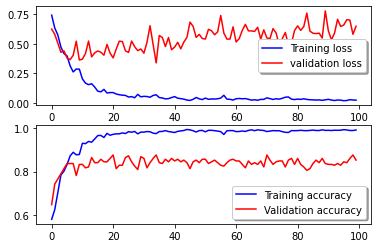

In [27]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r',
           label="validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'],
           color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)